In [1]:
# importing essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# loading dataset to the pandas dataframe
df = pd.read_csv('final_movies.csv')
df.head()

title  released_year rated_class run_time  stars total_ratings  \
0      Madame Web         2024.0          PG   1h 56m    3.8           28K   
1     Borderlands         2024.0         NaN   1h 42m    NaN           NaN   
2     Oppenheimer         2023.0         14A       3h    8.4          654K   
3  Dune: Part Two         2024.0          PG   2h 46m    9.1           28K   
4     Poor Things         2023.0         18A   2h 21m    8.3          115K   

                     genre                                            summary  
0  Action|Adventure|Sci-Fi  Cassandra Webb is a New York metropolis parame...  
1  Action|Adventure|Comedy  The popular video game set on the abandoned fi...  
2  Biography|Drama|History  The story of American scientist J. Robert Oppe...  
3   Action|Adventure|Drama  Paul Atreides unites with Chani and the Fremen...  
4     Comedy|Drama|Romance  The incredible tale about the fantastical evol...

In [3]:
# inspecting rows and columns of our dataset
df.shape

(3650, 8)

In [4]:
# Basic information of our dataset features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          3650 non-null   object 
 1   released_year  3580 non-null   float64
 2   rated_class    3415 non-null   object 
 3   run_time       3516 non-null   object 
 4   stars          3486 non-null   float64
 5   total_ratings  3486 non-null   object 
 6   genre          3616 non-null   object 
 7   summary        3613 non-null   object 
dtypes: float64(2), object(6)
memory usage: 228.3+ KB


We can see that every columns except title has some missing values

In [5]:
# calculating the missing percentage in each columns
(df.isnull().mean())* 100

title            0.000000
released_year    1.917808
rated_class      6.438356
run_time         3.671233
stars            4.493151
total_ratings    4.493151
genre            0.931507
summary          1.013699
dtype: float64

In [6]:
df['rated_class'].value_counts().keys()

Index(['PG', '14A', '18A', 'R', 'G', '13+', '16+', '18+', 'PG-13', 'TV-MA',
       'Not Rated', 'PA', 'AA', 'TV-14', '14+', '14', 'A', 'Unrated', 'TV-PG',
       '(Banned)', '18', 'Approved', 'TV-G', 'TV-Y7', 'RX', 'Passed', '7+'],
      dtype='object', name='rated_class')

## Data cleaning and preprocessing/formatting

In [7]:
class Utils:
    """
    Utility wrapper class that provides functionality for cleaning Helper class
    """
    number_pattern = re.compile(r'[0-9]*')
    
    @staticmethod
    def convert_to_minutes(run_time):
        minutes = 0
        x = run_time.split(' ')
        match = re.match(Utils.number_pattern, x[0])
        s = match.start()
        e = match.end()
        hours = int(x[0][s:e])
        minutes += int(match[0])* 60
        if len(x) > 1:
            match = re.match(Utils.number_pattern, x[1])
            s = match.start()
            e = match.end()
            mins = int(x[1][s:e])
            minutes += int(mins)
        return minutes


class DataCleaningHelper:
    '''
    Helper class to clean and transform total ratings, run time and rated class
    '''
    @staticmethod
    def convert_total_rating(item):
        if type(item) != float:
            if '.' in item:
                item = item.replace('K', '00')
                item = item.replace('M', '00000')
            else:
                item = item.replace('K', '000')
                item = item.replace('M', '000000')
            item = item.replace('.', '')
            return int(item)
        return np.nan

    @staticmethod
    def categorize_run_time(item):
        if type(item) == str:
            minutes = Utils.convert_to_minutes(item)
            if minutes < 90:
                return 'very short'
            elif minutes < 120:
                return 'short'
            elif minutes < 150:
                return 'medium'
            return 'long'
                
        else:
            return np.nan
    

    @staticmethod
    def categorize_rated_class(item):
        """
        Categorize ratings
        """
        if type(item) == str:
            if item in ['PG-13', '14', '14A', '14+', '13+', '16+']:
                return 'Teens'
            elif item in ['PG','G','TV-PG', 'TV-G', 'TV-Y7','7+']:
                return 'Kids'
            elif item in ['18','18+','R', 'TV-MA', 'A','AA']:
                return 'Adults'
            else:
                return 'Other'
        else:
            return np.nan
    

In [8]:
df.head(10)

title  released_year rated_class run_time  stars  \
0            Madame Web         2024.0          PG   1h 56m    3.8   
1           Borderlands         2024.0         NaN   1h 42m    NaN   
2           Oppenheimer         2023.0         14A       3h    8.4   
3        Dune: Part Two         2024.0          PG   2h 46m    9.1   
4           Poor Things         2023.0         18A   2h 21m    8.3   
5        Anyone But You         2023.0         14A   1h 43m    6.3   
6  The Zone of Interest         2023.0          PG   1h 45m    7.6   
7                  Dune         2021.0          PG   2h 35m    8.0   
8  Bob Marley: One Love         2024.0          PG   1h 47m    6.5   
9           Land of Bad         2024.0         14A   1h 53m    6.5   

  total_ratings                    genre  \
0           28K  Action|Adventure|Sci-Fi   
1           NaN  Action|Adventure|Comedy   
2          654K  Biography|Drama|History   
3           28K   Action|Adventure|Drama   
4          115K     Comedy|Drama|Romance   
5           41K           Comedy|Romance   
6           36K        Drama|History|War   
7          773K   Action|Adventure|Drama   
8           11K    Biography|Drama|Music   
9          7.6K          Action|Thriller   

                                             summary  
0  Cassandra Webb is a New York metropolis parame...  
1  The popular video game set on the abandoned fi...  
2  The story of American scientist J. Robert Oppe...  
3  Paul Atreides unites with Chani and the Fremen...  
4  The incredible tale about the fantastical evol...  
5  After an amazing first date, Bea and Ben's fie...  
6  Auschwitz commandant Rudolf Höss and his wife ...  
7  A noble family becomes embroiled in a war for ...  
8  The story of how reggae icon Bob Marley overca...  
9  A US Army special forces unit is ambushed duri...

In [9]:
df['total_ratings'] = df['total_ratings'].apply(DataCleaningHelper.convert_total_rating)
df['run_time'] = df['run_time'].apply(DataCleaningHelper.categorize_run_time)
df['rated_class'] = df['rated_class'].apply(DataCleaningHelper.categorize_rated_class)

In [10]:
df.head(10)

title  released_year rated_class run_time  stars  \
0            Madame Web         2024.0        Kids    short    3.8   
1           Borderlands         2024.0         NaN    short    NaN   
2           Oppenheimer         2023.0       Teens     long    8.4   
3        Dune: Part Two         2024.0        Kids     long    9.1   
4           Poor Things         2023.0       Other   medium    8.3   
5        Anyone But You         2023.0       Teens    short    6.3   
6  The Zone of Interest         2023.0        Kids    short    7.6   
7                  Dune         2021.0        Kids     long    8.0   
8  Bob Marley: One Love         2024.0        Kids    short    6.5   
9           Land of Bad         2024.0       Teens    short    6.5   

   total_ratings                    genre  \
0        28000.0  Action|Adventure|Sci-Fi   
1            NaN  Action|Adventure|Comedy   
2       654000.0  Biography|Drama|History   
3        28000.0   Action|Adventure|Drama   
4       115000.0     Comedy|Drama|Romance   
5        41000.0           Comedy|Romance   
6        36000.0        Drama|History|War   
7       773000.0   Action|Adventure|Drama   
8        11000.0    Biography|Drama|Music   
9         7600.0          Action|Thriller   

                                             summary  
0  Cassandra Webb is a New York metropolis parame...  
1  The popular video game set on the abandoned fi...  
2  The story of American scientist J. Robert Oppe...  
3  Paul Atreides unites with Chani and the Fremen...  
4  The incredible tale about the fantastical evol...  
5  After an amazing first date, Bea and Ben's fie...  
6  Auschwitz commandant Rudolf Höss and his wife ...  
7  A noble family becomes embroiled in a war for ...  
8  The story of how reggae icon Bob Marley overca...  
9  A US Army special forces unit is ambushed duri...

### Removing movies that are to be released

In [11]:
df[df['released_year'] > 2024].head()

title  released_year rated_class  \
50                              The Fantastic Four         2025.0         NaN   
103                               Superman: Legacy         2025.0         NaN   
243                                        Michael         2025.0         NaN   
406               Captain America: Brave New World         2025.0         NaN   
488  Mission: Impossible - Dead Reckoning Part Two         2025.0         NaN   

    run_time  stars  total_ratings                      genre  \
50       NaN    NaN            NaN    Action|Adventure|Sci-Fi   
103      NaN    NaN            NaN   Action|Adventure|Fantasy   
243      NaN    NaN            NaN    Biography|Drama|History   
406      NaN    NaN            NaN    Action|Adventure|Sci-Fi   
488      NaN    NaN            NaN  Action|Adventure|Thriller   

                                               summary  
50   One of Marvel's most iconic families makes it ...  
103  Follows the titular superhero as he reconciles...  
243  The story of the famous musician Michael Jacks...  
406  Plot kept under wraps. Fourth movie in the Cap...  
488  The 8th entry in the long running Mission Impo...

In [12]:
df = df[df['released_year'] <= 2024]
df.shape

(3560, 8)

In [13]:
df.reset_index(inplace=True, drop=True)

# Pandas profiling report in original dataset

In [14]:
# pandas profiling report before handling missing values and encodings
from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="Movies Report (pre)")
# profile.to_file("pre_report.html")

### Contd.. preprocessing

In [15]:
# function to get genre count to find frequent and ignore others
def get_genre_count(col: pd.Series)-> dict:
    genre_map = dict()
    for i in col:
        genres = i.split('|')
        for j in genres:
            if j in genre_map:
                genre_map[j] += 1
            else:
                genre_map[j] = 1
    return genre_map

genre_count = get_genre_count(df['genre'])
dict(sorted(genre_count.items(), key=lambda item: item[1], reverse=True))

{'Drama': 1789,
 'Comedy': 1122,
 'Action': 1071,
 'Adventure': 858,
 'Thriller': 658,
 'Crime': 604,
 'Romance': 517,
 'Horror': 447,
 'Mystery': 379,
 'Sci-Fi': 359,
 'Fantasy': 308,
 'Biography': 242,
 'Animation': 200,
 'Family': 174,
 'History': 118,
 'Music': 82,
 'Sport': 80,
 'War': 64,
 'Western': 43,
 'Musical': 40,
 'Documentary': 23,
 'Film-Noir': 10}

In [16]:
# selecting most frequent genres
frequent_genres = [k for k,v in genre_count.items() if v > 300]
frequent_genres

['Action',
 'Adventure',
 'Sci-Fi',
 'Comedy',
 'Drama',
 'Romance',
 'Thriller',
 'Fantasy',
 'Horror',
 'Mystery',
 'Crime']

In [17]:
# encoding genre as one hot encoding; only for frequent genre
final_genre_array = np.array([
    [1,1,1,0,0,0,0,0,0,0,0]
])
for i in df['genre'][1:]:
    genres = i.split('|')
    genre_array = np.zeros(11)
    if 'Action' in genres:
        genre_array[0] = 1
    if 'Adventure' in genres:
        genre_array[1] = 1
    if 'Sci-Fi' in genres:
        genre_array[2] = 1
    if 'Comedy' in genres:
        genre_array[3] = 1
    if 'Drama' in genres:
        genre_array[4] = 1
    if 'Romance' in genres:
        genre_array[5] = 1
    if 'Thriller' in genres:
        genre_array[6] = 1
    if 'Fantasy' in genres:
        genre_array[7] = 1
    if 'Horror' in genres:
        genre_array[8] = 1
    if 'Mystery' in genres:
        genre_array[9] = 1
    if 'Crime' in genres:
        genre_array[10] = 1
    final_genre_array = np.vstack((final_genre_array, genre_array))

final_genre_array.shape

(3560, 11)

In [18]:
# result after transformation
genre_dataframe = pd.DataFrame(final_genre_array, columns=frequent_genres)
genre_dataframe

Action  Adventure  Sci-Fi  Comedy  Drama  Romance  Thriller  Fantasy  \
0        1.0        1.0     1.0     0.0    0.0      0.0       0.0      0.0   
1        1.0        1.0     0.0     1.0    0.0      0.0       0.0      0.0   
2        0.0        0.0     0.0     0.0    1.0      0.0       0.0      0.0   
3        1.0        1.0     0.0     0.0    1.0      0.0       0.0      0.0   
4        0.0        0.0     0.0     1.0    1.0      1.0       0.0      0.0   
...      ...        ...     ...     ...    ...      ...       ...      ...   
3555     0.0        0.0     0.0     0.0    1.0      0.0       0.0      0.0   
3556     1.0        0.0     0.0     0.0    0.0      0.0       1.0      0.0   
3557     0.0        0.0     0.0     1.0    0.0      0.0       0.0      0.0   
3558     0.0        0.0     0.0     0.0    1.0      0.0       0.0      0.0   
3559     1.0        0.0     0.0     1.0    0.0      0.0       0.0      0.0   

      Horror  Mystery  Crime  
0        0.0      0.0    0.0  
1        0.0      0.0    0.0  
2        0.0      0.0    0.0  
3        0.0      0.0    0.0  
4        0.0      0.0    0.0  
...      ...      ...    ...  
3555     0.0      0.0    0.0  
3556     0.0      0.0    1.0  
3557     0.0      0.0    0.0  
3558     0.0      0.0    0.0  
3559     0.0      0.0    1.0  

[3560 rows x 11 columns]

In [19]:
# combining genre df to our main dataframe
df = pd.merge(df, genre_dataframe, left_index=True, right_index=True)
del df['genre']
df.head()

title  released_year rated_class run_time  stars  total_ratings  \
0      Madame Web         2024.0        Kids    short    3.8        28000.0   
1     Borderlands         2024.0         NaN    short    NaN            NaN   
2     Oppenheimer         2023.0       Teens     long    8.4       654000.0   
3  Dune: Part Two         2024.0        Kids     long    9.1        28000.0   
4     Poor Things         2023.0       Other   medium    8.3       115000.0   

                                             summary  Action  Adventure  \
0  Cassandra Webb is a New York metropolis parame...     1.0        1.0   
1  The popular video game set on the abandoned fi...     1.0        1.0   
2  The story of American scientist J. Robert Oppe...     0.0        0.0   
3  Paul Atreides unites with Chani and the Fremen...     1.0        1.0   
4  The incredible tale about the fantastical evol...     0.0        0.0   

   Sci-Fi  Comedy  Drama  Romance  Thriller  Fantasy  Horror  Mystery  Crime  
0     1.0     0.0    0.0      0.0       0.0      0.0     0.0      0.0    0.0  
1     0.0     1.0    0.0      0.0       0.0      0.0     0.0      0.0    0.0  
2     0.0     0.0    1.0      0.0       0.0      0.0     0.0      0.0    0.0  
3     0.0     0.0    1.0      0.0       0.0      0.0     0.0      0.0    0.0  
4     0.0     1.0    1.0      1.0       0.0      0.0     0.0      0.0    0.0

# Data visualization

#### Movies released year distribution

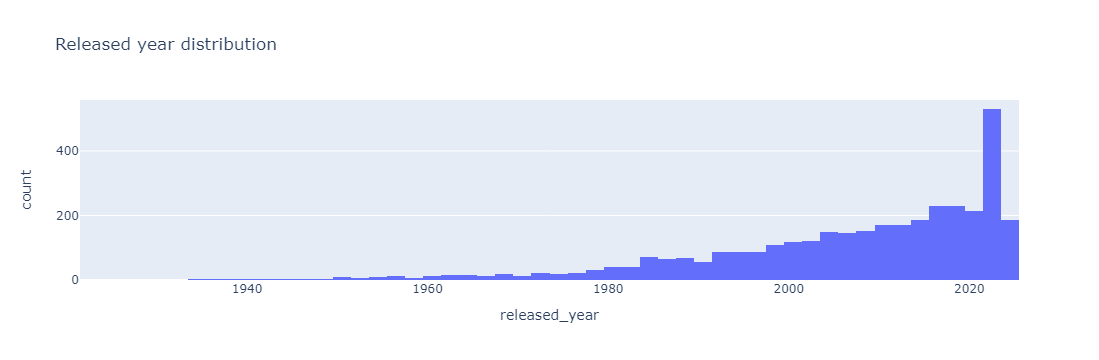

In [20]:
fig = px.histogram(df, x='released_year', title='Released year distribution')
fig.show()

#### Star distribution plot

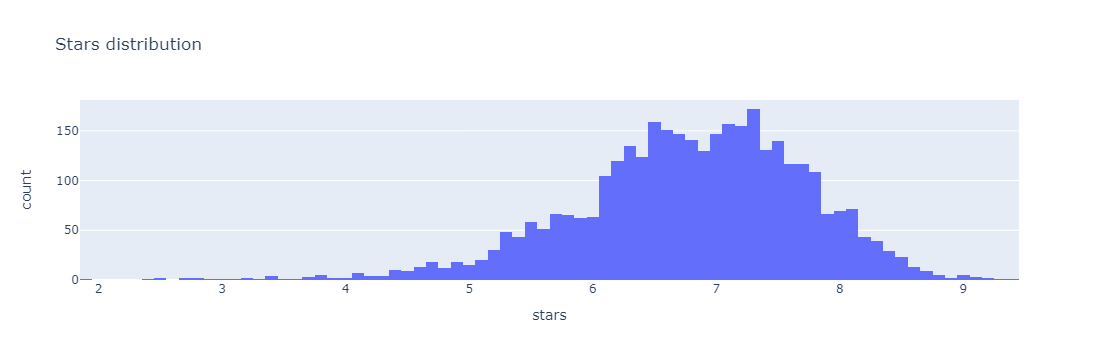

In [21]:
fig = px.histogram(df, x='stars', title='Stars distribution')
fig.show()

In [22]:
df['stars'].describe()

count    3486.000000
mean        6.788239
std         0.940124
min         1.900000
25%         6.200000
50%         6.900000
75%         7.400000
max         9.400000
Name: stars, dtype: float64

#### Stars and rating relation

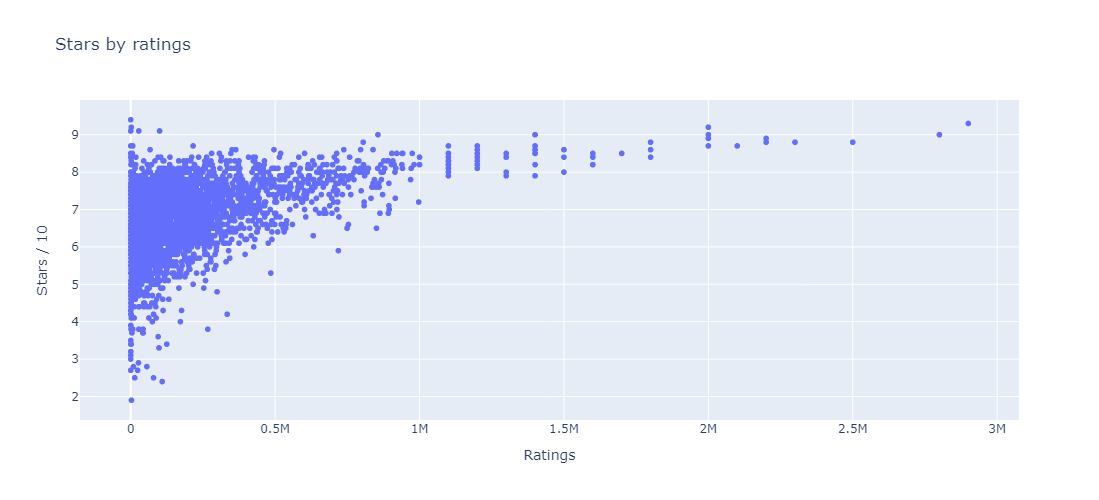

In [23]:
fig = px.scatter(x=df['total_ratings'], y=df['stars'], height=500, title="Stars by ratings")
fig.update_layout(
    xaxis_title='Ratings',
    yaxis_title='Stars / 10',
)
fig.show()

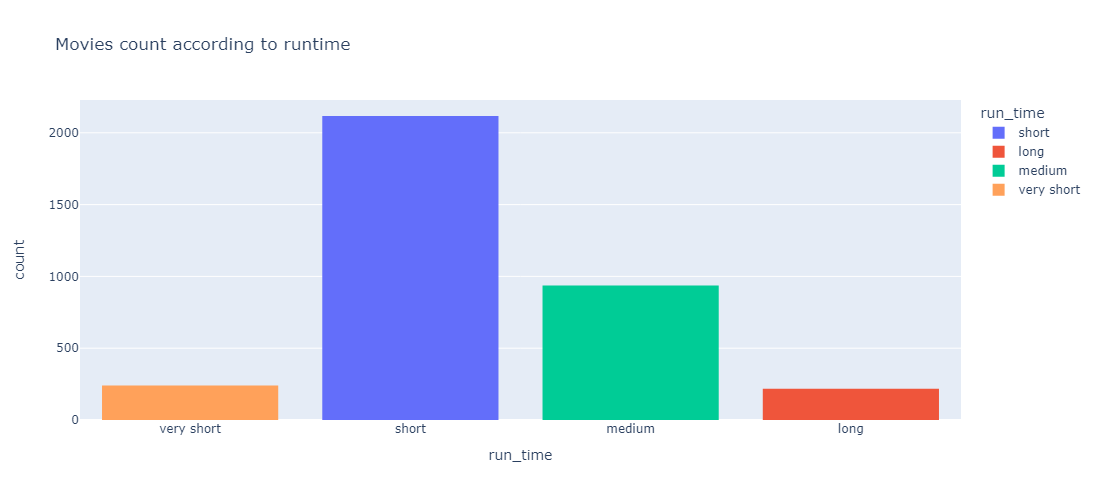

In [24]:
fig = px.histogram(df, x='run_time', color='run_time', title='Movies count according to runtime', height=500)
fig.update_layout(xaxis={'categoryarray':['very short','short','medium','long']})
fig.show()

#### movies distribution according to rated class

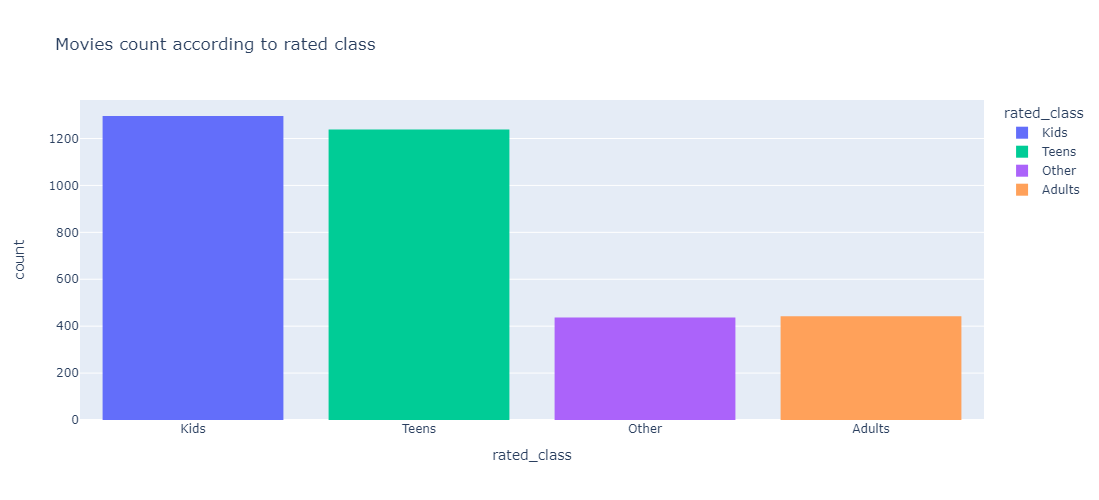

In [25]:
fig = px.histogram(df, x='rated_class', color='rated_class', title='Movies count according to rated class', height=500)
fig.show()

#### Grouping by movies rated class and runtime

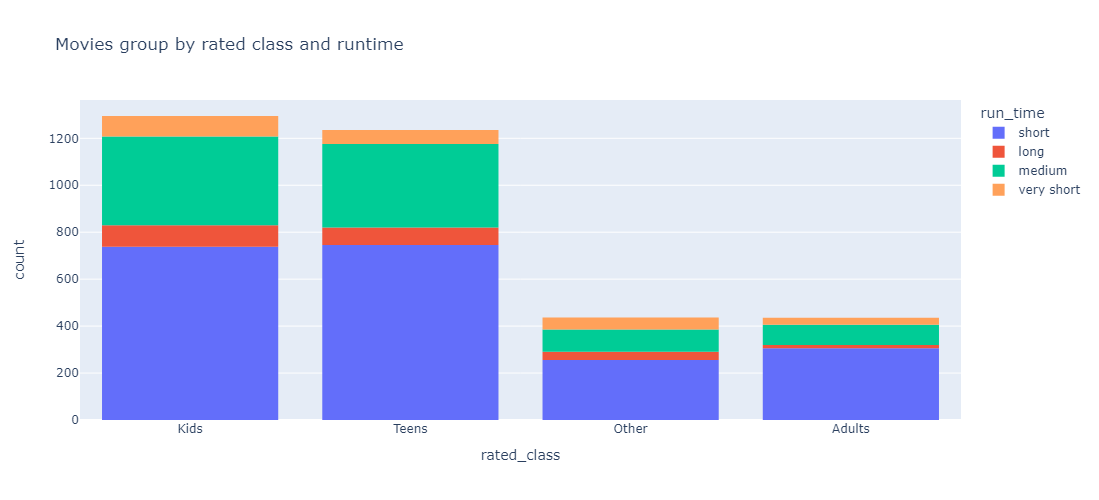

In [26]:
fig = px.histogram(df, x='rated_class', color='run_time', title='Movies group by rated class and runtime', height=500)
fig.show()

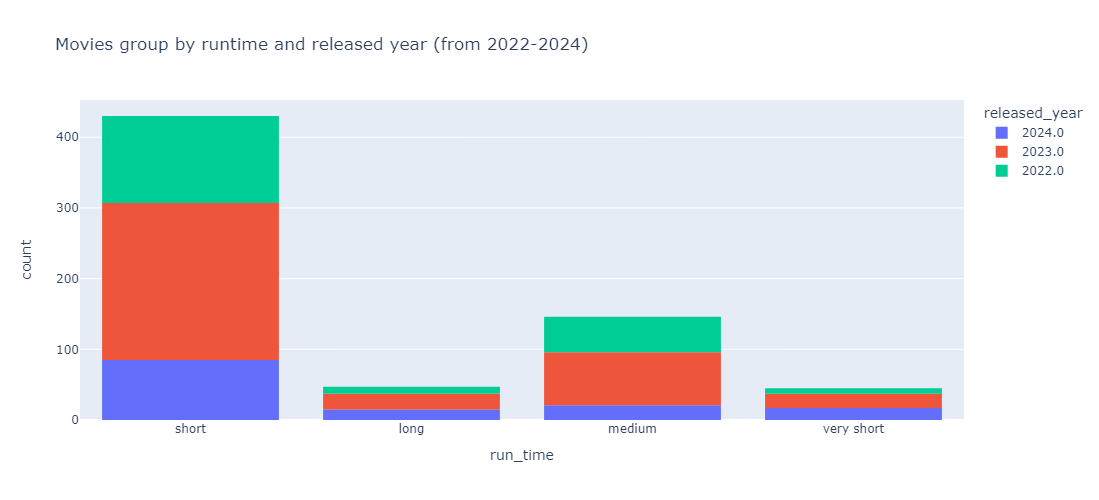

In [27]:
fig = px.histogram(df[df['released_year']>=2022], x='run_time', color='released_year', title='Movies group by runtime and released year (from 2022-2024)', height=500)
fig.show()

# Data Transformation and Encoding

#### Handling missing values

In [28]:
# number of missing values according to columns
df.isna().sum()

title              0
released_year      0
rated_class      147
run_time          48
stars             74
total_ratings     74
summary            1
Action             0
Adventure          0
Sci-Fi             0
Comedy             0
Drama              0
Romance            0
Thriller           0
Fantasy            0
Horror             0
Mystery            0
Crime              0
dtype: int64

In [29]:
# filling run_time column's null value with median
df['run_time'] = df['run_time'].fillna('medium')
df['summary'] = df['summary'].fillna('')
df = df[~pd.isna(df['rated_class'])]
df.reset_index(inplace=True, drop=True)

In [30]:
# Encoding run_time using Ordinal encoder as it follows an order of vs,s m and long
ordinal_encoder = OrdinalEncoder()
df['run_time'] = pd.Series(ordinal_encoder.fit_transform(df[['run_time']]).squeeze())

In [31]:
# imputing stars and total_rating's null values using KNN inputer
knn_imputer = KNNImputer(n_neighbors=7)
selected_cols = ['released_year', 'run_time', 'stars', 'total_ratings']
selected_cols.extend(frequent_genres)
imputed_data = knn_imputer.fit_transform(df[selected_cols])
temp = pd.DataFrame(imputed_data, columns=selected_cols)
temp.head()

released_year  run_time  stars  total_ratings  Action  Adventure  Sci-Fi  \
0         2024.0       2.0    3.8        28000.0     1.0        1.0     1.0   
1         2023.0       0.0    8.4       654000.0     0.0        0.0     0.0   
2         2024.0       0.0    9.1        28000.0     1.0        1.0     0.0   
3         2023.0       1.0    8.3       115000.0     0.0        0.0     0.0   
4         2023.0       2.0    6.3        41000.0     0.0        0.0     0.0   

   Comedy  Drama  Romance  Thriller  Fantasy  Horror  Mystery  Crime  
0     0.0    0.0      0.0       0.0      0.0     0.0      0.0    0.0  
1     0.0    1.0      0.0       0.0      0.0     0.0      0.0    0.0  
2     0.0    1.0      0.0       0.0      0.0     0.0      0.0    0.0  
3     1.0    1.0      1.0       0.0      0.0     0.0      0.0    0.0  
4     1.0    0.0      1.0       0.0      0.0     0.0      0.0    0.0

In [32]:
df.head()

title  released_year rated_class  run_time  stars  total_ratings  \
0      Madame Web         2024.0        Kids       2.0    3.8        28000.0   
1     Oppenheimer         2023.0       Teens       0.0    8.4       654000.0   
2  Dune: Part Two         2024.0        Kids       0.0    9.1        28000.0   
3     Poor Things         2023.0       Other       1.0    8.3       115000.0   
4  Anyone But You         2023.0       Teens       2.0    6.3        41000.0   

                                             summary  Action  Adventure  \
0  Cassandra Webb is a New York metropolis parame...     1.0        1.0   
1  The story of American scientist J. Robert Oppe...     0.0        0.0   
2  Paul Atreides unites with Chani and the Fremen...     1.0        1.0   
3  The incredible tale about the fantastical evol...     0.0        0.0   
4  After an amazing first date, Bea and Ben's fie...     0.0        0.0   

   Sci-Fi  Comedy  Drama  Romance  Thriller  Fantasy  Horror  Mystery  Crime  
0     1.0     0.0    0.0      0.0       0.0      0.0     0.0      0.0    0.0  
1     0.0     0.0    1.0      0.0       0.0      0.0     0.0      0.0    0.0  
2     0.0     0.0    1.0      0.0       0.0      0.0     0.0      0.0    0.0  
3     0.0     1.0    1.0      1.0       0.0      0.0     0.0      0.0    0.0  
4     0.0     1.0    0.0      1.0       0.0      0.0     0.0      0.0    0.0

In [33]:
# replacing our main dataframe's stars and total ratings from imputed series
# df.iloc[:, 4:6] = temp.iloc[:, 2:4]
df[['stars', 'total_ratings']] = temp[['stars', 'total_ratings']]

In [34]:
df.isna().sum()

title            0
released_year    0
rated_class      0
run_time         0
stars            0
total_ratings    0
summary          0
Action           0
Adventure        0
Sci-Fi           0
Comedy           0
Drama            0
Romance          0
Thriller         0
Fantasy          0
Horror           0
Mystery          0
Crime            0
dtype: int64

In [35]:
# One hot encoding for out rated class feature
df = pd.concat([df, pd.get_dummies(df['rated_class'])], axis=1)
df.drop('rated_class', axis=1, inplace=True)
df.head()

title  released_year  run_time  stars  total_ratings  \
0      Madame Web         2024.0       2.0    3.8        28000.0   
1     Oppenheimer         2023.0       0.0    8.4       654000.0   
2  Dune: Part Two         2024.0       0.0    9.1        28000.0   
3     Poor Things         2023.0       1.0    8.3       115000.0   
4  Anyone But You         2023.0       2.0    6.3        41000.0   

                                             summary  Action  Adventure  \
0  Cassandra Webb is a New York metropolis parame...     1.0        1.0   
1  The story of American scientist J. Robert Oppe...     0.0        0.0   
2  Paul Atreides unites with Chani and the Fremen...     1.0        1.0   
3  The incredible tale about the fantastical evol...     0.0        0.0   
4  After an amazing first date, Bea and Ben's fie...     0.0        0.0   

   Sci-Fi  Comedy  ...  Romance  Thriller  Fantasy  Horror  Mystery  Crime  \
0     1.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
1     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
2     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
3     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   
4     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   

   Adults   Kids  Other  Teens  
0   False   True  False  False  
1   False  False  False   True  
2   False   True  False  False  
3   False  False   True  False  
4   False  False  False   True  

[5 rows x 21 columns]

In [36]:
df.to_csv('encoded_dataset.csv', sep=',', index=False)

In [37]:
df=pd.read_csv('encoded_dataset.csv')
df.head()

title  released_year  run_time  stars  total_ratings  \
0      Madame Web         2024.0       2.0    3.8        28000.0   
1     Oppenheimer         2023.0       0.0    8.4       654000.0   
2  Dune: Part Two         2024.0       0.0    9.1        28000.0   
3     Poor Things         2023.0       1.0    8.3       115000.0   
4  Anyone But You         2023.0       2.0    6.3        41000.0   

                                             summary  Action  Adventure  \
0  Cassandra Webb is a New York metropolis parame...     1.0        1.0   
1  The story of American scientist J. Robert Oppe...     0.0        0.0   
2  Paul Atreides unites with Chani and the Fremen...     1.0        1.0   
3  The incredible tale about the fantastical evol...     0.0        0.0   
4  After an amazing first date, Bea and Ben's fie...     0.0        0.0   

   Sci-Fi  Comedy  ...  Romance  Thriller  Fantasy  Horror  Mystery  Crime  \
0     1.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
1     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
2     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
3     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   
4     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   

   Adults   Kids  Other  Teens  
0   False   True  False  False  
1   False  False  False   True  
2   False   True  False  False  
3   False  False   True  False  
4   False  False  False   True  

[5 rows x 21 columns]

# Outlier Detection and Treatment

In [38]:
class DataTransformer:
    
    @staticmethod
    def log_transformer(data:pd.Series):
        return np.log(data)
        
    @staticmethod
    def log10_transformer(data:pd.Series):
        return np.log10(data)

    @staticmethod
    def sqrt_transformer(data:pd.Series):
        return np.sqrt(data)

    @staticmethod
    def quantile_capping(data:pd.Series, q=(0.01, 0.99)):
        floor, cap = data.quantile(q[0]), data.quantile(q[1])
        x = np.where(data<floor, floor, data)
        x = np.where(x > cap, cap, x)
        return pd.Series(x)

    @staticmethod
    def power_transformation(data:pd.Series):
        pt = PowerTransformer()
        return pd.Series(pt.fit_transform(data.values.reshape(-1,1)).squeeze())
    

In [39]:
class PlottingHelper:

    @staticmethod
    def boxplots(titles, values):
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.boxplot(values[0])
        plt.title(titles[0])
        
        plt.subplot(2, 2, 2)
        plt.boxplot(values[1])
        plt.title(titles[1])
        
        plt.subplot(2, 2, 3)
        plt.boxplot(values[2])
        plt.title(titles[2])
        
        plt.subplot(2, 2, 4)
        plt.boxplot(values[3])
        plt.title(titles[3])

    @staticmethod
    def distribution(titles, values):
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.hist(values[0])
        plt.title(titles[0])
        
        plt.subplot(2, 2, 2)
        plt.hist(values[1])
        plt.title(titles[1])
        
        plt.subplot(2, 2, 3)
        plt.hist(values[2])
        plt.title(titles[2])
        
        plt.subplot(2, 2, 4)
        plt.hist(values[3])
        plt.title(titles[3])

In [40]:
stars_dict = {
    'original': df['stars'],
    'Log Transformed': DataTransformer.log_transformer(df['stars']),
    'Quantile Capped': DataTransformer.quantile_capping(df['stars']),
    'Log 10 transformation': DataTransformer.log10_transformer(df['stars'])
}

total_ratings_dict = {
    'original': df['total_ratings'],
    'Log Transformed': DataTransformer.log_transformer(df['total_ratings']),
    'Quantile Capped': DataTransformer.quantile_capping(df['total_ratings'], q=(0.01, 0.98)),
    'Capped and Log transformed': DataTransformer.log_transformer(DataTransformer.quantile_capping(df['total_ratings'], q=(0.01, 0.98)))
}

released_year_dict = {
    'original': df['released_year'],
    'Log Transformed': DataTransformer.log_transformer(df['released_year']),
    'Quantile Capped': DataTransformer.quantile_capping(df['released_year']),
    'Capped and Log Transformation': DataTransformer.log_transformer(DataTransformer.quantile_capping(df['released_year']))
}

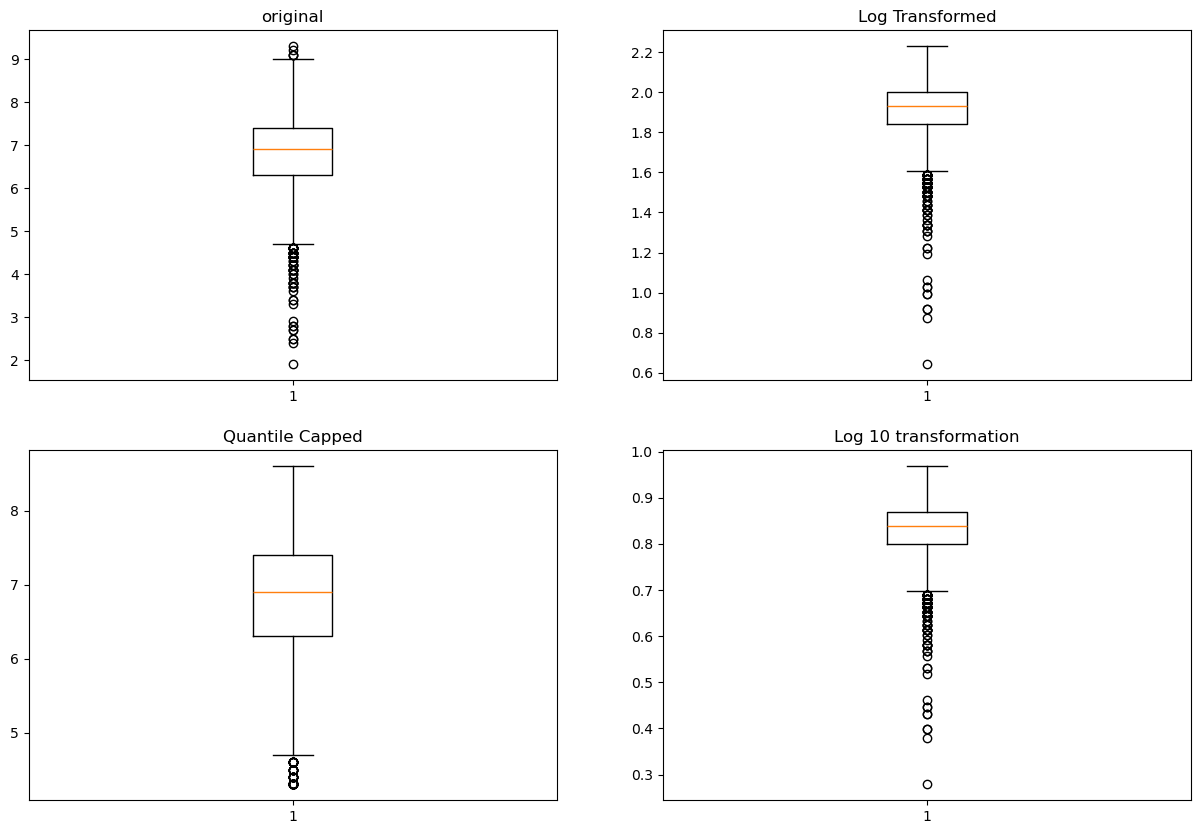

In [41]:
PlottingHelper.boxplots(list(stars_dict.keys()), list(stars_dict.values()))

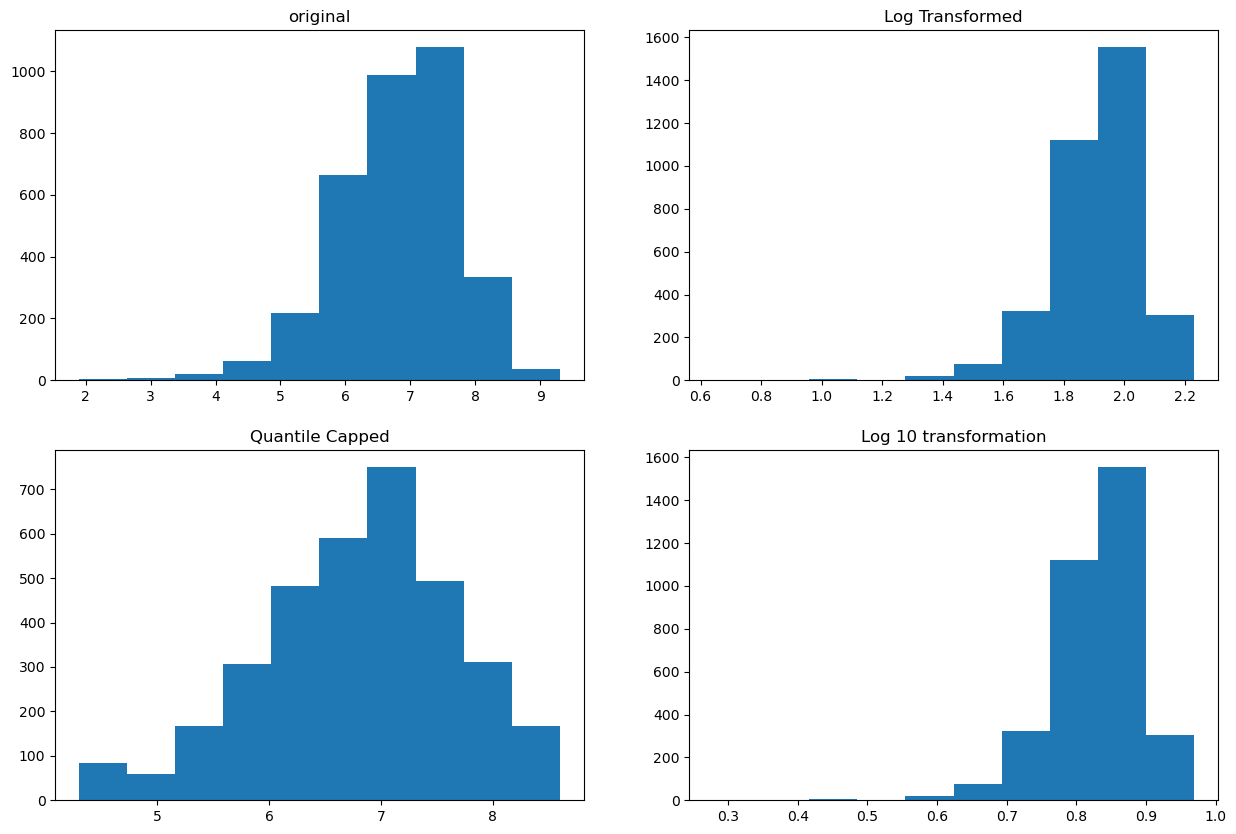

In [42]:
PlottingHelper.distribution(list(stars_dict.keys()), list(stars_dict.values()))

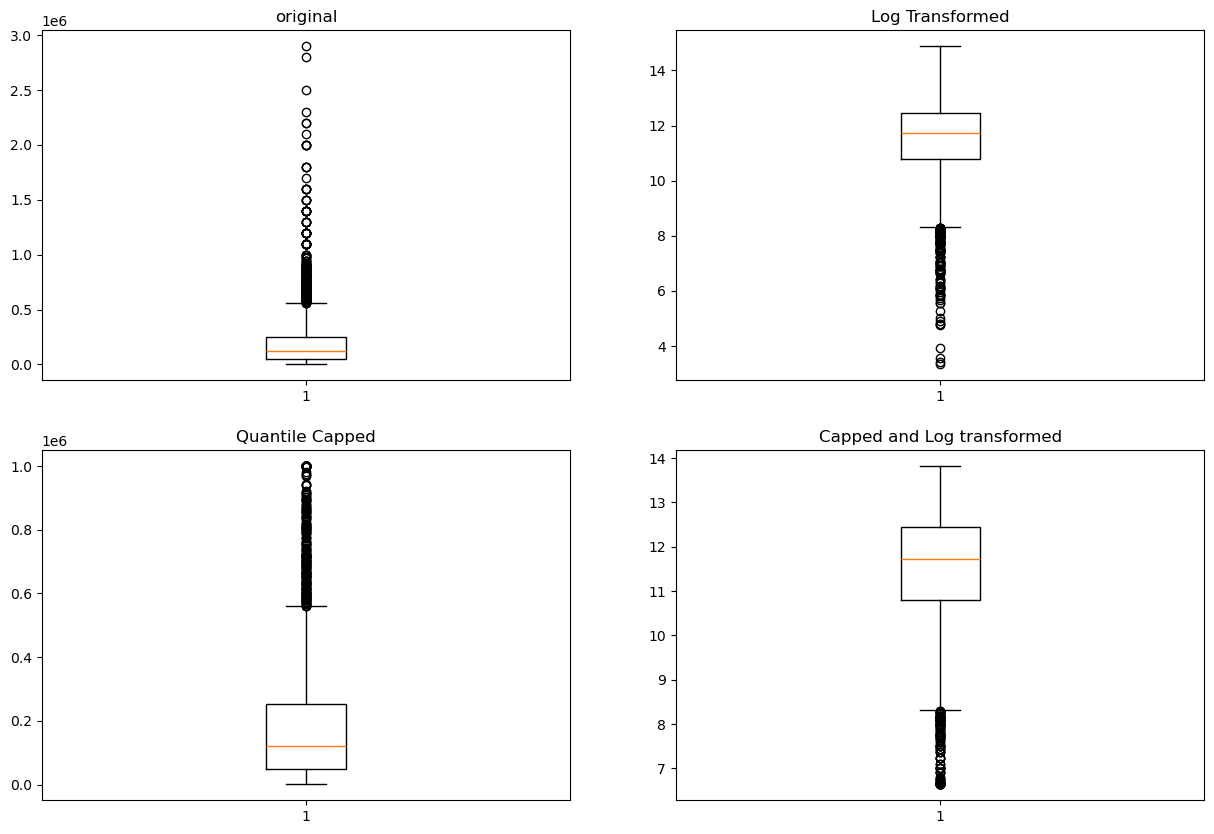

In [43]:
PlottingHelper.boxplots(list(total_ratings_dict.keys()), list(total_ratings_dict.values()))

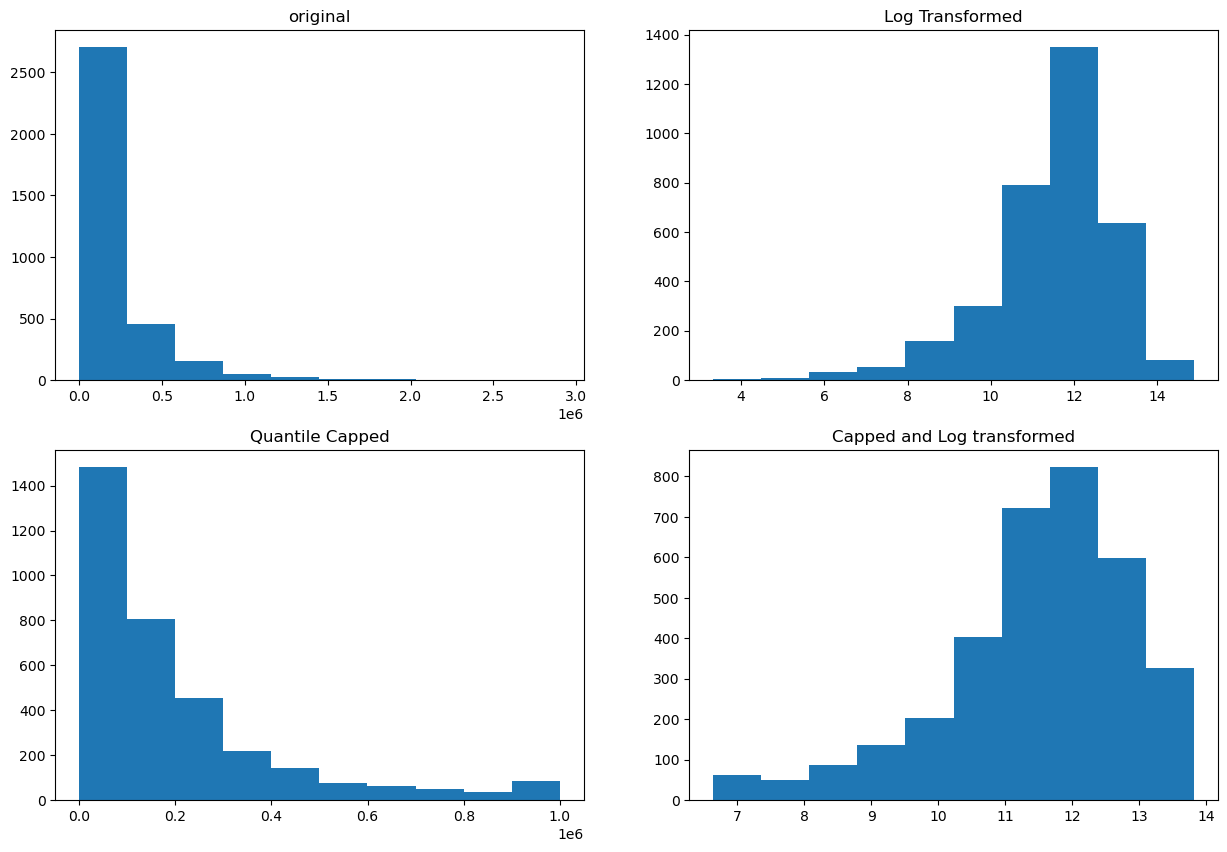

In [44]:
PlottingHelper.distribution(list(total_ratings_dict.keys()), list(total_ratings_dict.values()))

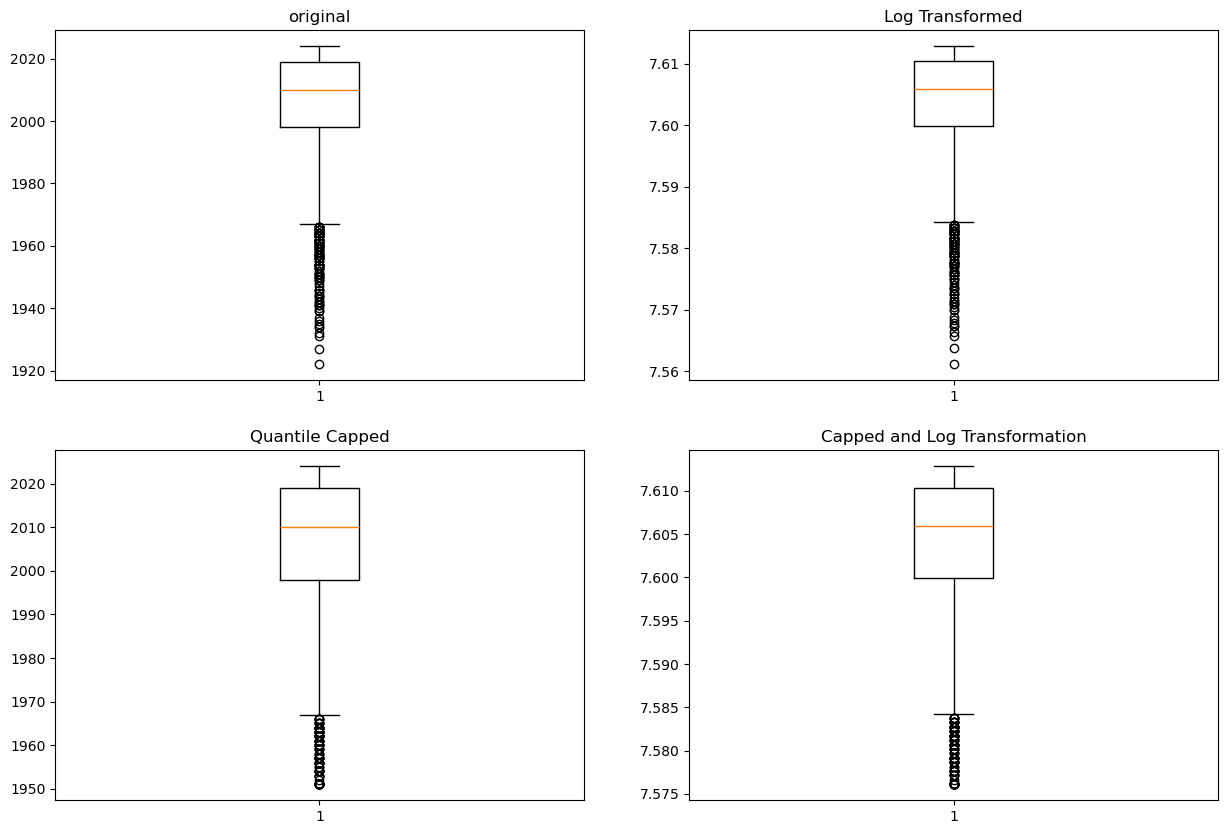

In [45]:
PlottingHelper.boxplots(list(released_year_dict.keys()), list(released_year_dict.values()))

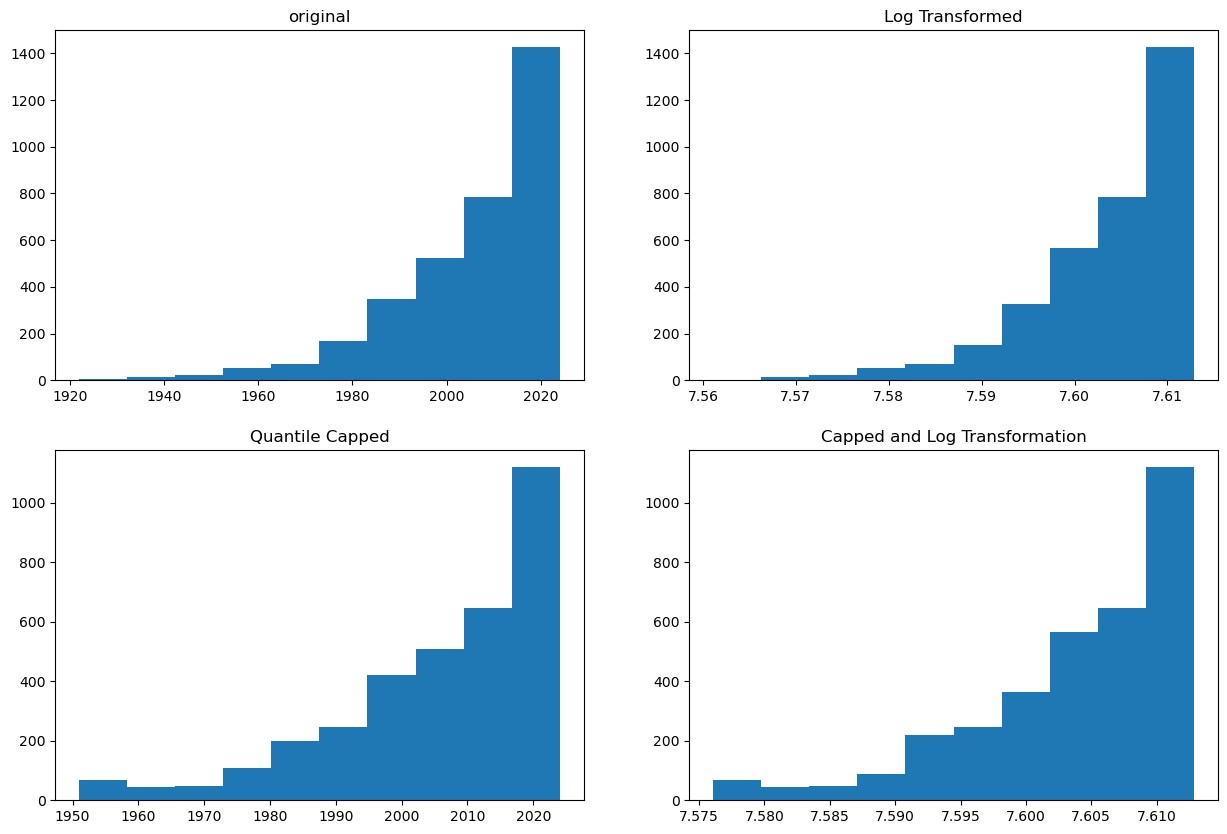

In [46]:
PlottingHelper.distribution(list(released_year_dict.keys()), list(released_year_dict.values()))

In [47]:
# transforming stars, total ratings and released year

In [48]:
df['stars'].iloc[:] = DataTransformer.quantile_capping(df['stars'])
df['total_ratings'].iloc[:] = DataTransformer.log_transformer(DataTransformer.quantile_capping(df['total_ratings'], q=(0.01, 0.98)))
df['released_year'].iloc[:] = DataTransformer.log_transformer(DataTransformer.quantile_capping(df['released_year']))

C:\Users\rojit\AppData\Local\Temp\ipykernel_13728\3364437945.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rojit\AppData\Local\Temp\ipykernel_13728\3364437945.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rojit\AppData\Local\Temp\ipykernel_13728\3364437945.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
df.head()

title  released_year  run_time  stars  total_ratings  \
0      Madame Web       7.612831       2.0    4.3      10.239960   
1     Oppenheimer       7.612337       0.0    8.4      13.390863   
2  Dune: Part Two       7.612831       0.0    8.6      10.239960   
3     Poor Things       7.612337       1.0    8.3      11.652687   
4  Anyone But You       7.612337       2.0    6.3      10.621327   

                                             summary  Action  Adventure  \
0  Cassandra Webb is a New York metropolis parame...     1.0        1.0   
1  The story of American scientist J. Robert Oppe...     0.0        0.0   
2  Paul Atreides unites with Chani and the Fremen...     1.0        1.0   
3  The incredible tale about the fantastical evol...     0.0        0.0   
4  After an amazing first date, Bea and Ben's fie...     0.0        0.0   

   Sci-Fi  Comedy  ...  Romance  Thriller  Fantasy  Horror  Mystery  Crime  \
0     1.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
1     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
2     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
3     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   
4     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   

   Adults   Kids  Other  Teens  
0   False   True  False  False  
1   False  False  False   True  
2   False   True  False  False  
3   False  False   True  False  
4   False  False  False   True  

[5 rows x 21 columns]

In [50]:
# standarizing using standard scaler

In [51]:
df[['released_year', 'stars', 'total_ratings']] = StandardScaler().fit_transform(df[['released_year', 'stars', 'total_ratings']])

In [52]:
df.head()

title  released_year  run_time     stars  total_ratings  \
0      Madame Web       1.099581       2.0 -2.830607      -0.863486   
1     Oppenheimer       1.038894       0.0  1.801267       1.331283   
2  Dune: Part Two       1.099581       0.0  2.027212      -0.863486   
3     Poor Things       1.038894       1.0  1.688294       0.120553   
4  Anyone But You       1.038894       2.0 -0.571157      -0.597844   

                                             summary  Action  Adventure  \
0  Cassandra Webb is a New York metropolis parame...     1.0        1.0   
1  The story of American scientist J. Robert Oppe...     0.0        0.0   
2  Paul Atreides unites with Chani and the Fremen...     1.0        1.0   
3  The incredible tale about the fantastical evol...     0.0        0.0   
4  After an amazing first date, Bea and Ben's fie...     0.0        0.0   

   Sci-Fi  Comedy  ...  Romance  Thriller  Fantasy  Horror  Mystery  Crime  \
0     1.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
1     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
2     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
3     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   
4     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   

   Adults   Kids  Other  Teens  
0   False   True  False  False  
1   False  False  False   True  
2   False   True  False  False  
3   False  False   True  False  
4   False  False  False   True  

[5 rows x 21 columns]

In [53]:
neumerical_df = df.drop(['title', 'summary'], axis=1)

# Text Processing

In [54]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [55]:
# text preprocessing func
def clean_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens if token.isalnum()]

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

# function to convert words to numbers after cleaning
def vectorize_text(s: pd.Series):
    vec = TfidfVectorizer()
    x = vec.fit_transform(s)
    return pd.DataFrame(x.toarray(), columns=vec.get_feature_names_out())

    

In [56]:
# cleaning text 
df['summary'] = df['summary'].apply(clean_text)

In [57]:
df.head()

title  released_year  run_time     stars  total_ratings  \
0      Madame Web       1.099581       2.0 -2.830607      -0.863486   
1     Oppenheimer       1.038894       0.0  1.801267       1.331283   
2  Dune: Part Two       1.099581       0.0  2.027212      -0.863486   
3     Poor Things       1.038894       1.0  1.688294       0.120553   
4  Anyone But You       1.038894       2.0 -0.571157      -0.597844   

                                             summary  Action  Adventure  \
0  cassandra webb new york metropolis paramedic b...     1.0        1.0   
1  story american scientist robert oppenheimer ro...     0.0        0.0   
2  paul atreides unites chani fremen seeking reve...     1.0        1.0   
3  incredible tale fantastical evolution bella ba...     0.0        0.0   
4  amazing first date bea ben fiery attraction tu...     0.0        0.0   

   Sci-Fi  Comedy  ...  Romance  Thriller  Fantasy  Horror  Mystery  Crime  \
0     1.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
1     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
2     0.0     0.0  ...      0.0       0.0      0.0     0.0      0.0    0.0   
3     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   
4     0.0     1.0  ...      1.0       0.0      0.0     0.0      0.0    0.0   

   Adults   Kids  Other  Teens  
0   False   True  False  False  
1   False  False  False   True  
2   False   True  False  False  
3   False  False   True  False  
4   False  False  False   True  

[5 rows x 21 columns]

In [58]:
text_transformed_df = vectorize_text(df['summary'])
text_transformed_df.shape

(3413, 10183)

In [59]:
# concating o
final_df = pd.concat([df, text_transformed_df], axis=1)
final_df.drop(['title', 'summary'], inplace=True, axis=1)
final_df.shape

(3413, 10201)

In [60]:
final_df

released_year  run_time     stars  total_ratings  Action  Adventure  \
0          1.099581       2.0 -2.830607      -0.863486     1.0        1.0   
1          1.038894       0.0  1.801267       1.331283     0.0        0.0   
2          1.099581       0.0  2.027212      -0.863486     1.0        1.0   
3          1.038894       1.0  1.688294       0.120553     0.0        0.0   
4          1.038894       2.0 -0.571157      -0.597844     0.0        0.0   
...             ...       ...       ...            ...     ...        ...   
3408       0.674143       3.0 -0.571157      -1.211060     0.0        0.0   
3409       0.552318       2.0 -0.232239       0.120553     1.0        0.0   
3410      -0.734194       2.0  0.784514      -0.393223     0.0        0.0   
3411      -1.537414       1.0  0.332624      -0.276862     0.0        0.0   
3412      -1.475441       2.0  0.106679      -0.090002     1.0        0.0   

      Sci-Fi  Comedy  Drama  Romance  ...  zombie  zone  zoo  zooni  zorg  \
0        1.0     0.0    0.0      0.0  ...     0.0   0.0  0.0    0.0   0.0   
1        0.0     0.0    1.0      0.0  ...     0.0   0.0  0.0    0.0   0.0   
2        0.0     0.0    1.0      0.0  ...     0.0   0.0  0.0    0.0   0.0   
3        0.0     1.0    1.0      1.0  ...     0.0   0.0  0.0    0.0   0.0   
4        0.0     1.0    0.0      1.0  ...     0.0   0.0  0.0    0.0   0.0   
...      ...     ...    ...      ...  ...     ...   ...  ...    ...   ...   
3408     0.0     0.0    1.0      0.0  ...     0.0   0.0  0.0    0.0   0.0   
3409     0.0     0.0    0.0      0.0  ...     0.0   0.0  0.0    0.0   0.0   
3410     0.0     1.0    0.0      0.0  ...     0.0   0.0  0.0    0.0   0.0   
3411     0.0     0.0    1.0      0.0  ...     0.0   0.0  0.0    0.0   0.0   
3412     0.0     1.0    0.0      0.0  ...     0.0   0.0  0.0    0.0   0.0   

      zorro  zuckerberg  zuko  zulu  zurg  
0       0.0         0.0   0.0   0.0   0.0  
1       0.0         0.0   0.0   0.0   0.0  
2       0.0         0.0   0.0   0.0   0.0  
3       0.0         0.0   0.0   0.0   0.0  
4       0.0         0.0   0.0   0.0   0.0  
...     ...         ...   ...   ...   ...  
3408    0.0         0.0   0.0   0.0   0.0  
3409    0.0         0.0   0.0   0.0   0.0  
3410    0.0         0.0   0.0   0.0   0.0  
3411    0.0         0.0   0.0   0.0   0.0  
3412    0.0         0.0   0.0   0.0   0.0  

[3413 rows x 10201 columns]

# Applying Clustering

#### clustering our neumerical df (without text) which has 19 dimentions only

In [61]:
neumerical_df

released_year  run_time     stars  total_ratings  Action  Adventure  \
0          1.099581       2.0 -2.830607      -0.863486     1.0        1.0   
1          1.038894       0.0  1.801267       1.331283     0.0        0.0   
2          1.099581       0.0  2.027212      -0.863486     1.0        1.0   
3          1.038894       1.0  1.688294       0.120553     0.0        0.0   
4          1.038894       2.0 -0.571157      -0.597844     0.0        0.0   
...             ...       ...       ...            ...     ...        ...   
3408       0.674143       3.0 -0.571157      -1.211060     0.0        0.0   
3409       0.552318       2.0 -0.232239       0.120553     1.0        0.0   
3410      -0.734194       2.0  0.784514      -0.393223     0.0        0.0   
3411      -1.537414       1.0  0.332624      -0.276862     0.0        0.0   
3412      -1.475441       2.0  0.106679      -0.090002     1.0        0.0   

      Sci-Fi  Comedy  Drama  Romance  Thriller  Fantasy  Horror  Mystery  \
0        1.0     0.0    0.0      0.0       0.0      0.0     0.0      0.0   
1        0.0     0.0    1.0      0.0       0.0      0.0     0.0      0.0   
2        0.0     0.0    1.0      0.0       0.0      0.0     0.0      0.0   
3        0.0     1.0    1.0      1.0       0.0      0.0     0.0      0.0   
4        0.0     1.0    0.0      1.0       0.0      0.0     0.0      0.0   
...      ...     ...    ...      ...       ...      ...     ...      ...   
3408     0.0     0.0    1.0      0.0       0.0      0.0     0.0      0.0   
3409     0.0     0.0    0.0      0.0       1.0      0.0     0.0      0.0   
3410     0.0     1.0    0.0      0.0       0.0      0.0     0.0      0.0   
3411     0.0     0.0    1.0      0.0       0.0      0.0     0.0      0.0   
3412     0.0     1.0    0.0      0.0       0.0      0.0     0.0      0.0   

      Crime  Adults   Kids  Other  Teens  
0       0.0   False   True  False  False  
1       0.0   False  False  False   True  
2       0.0   False   True  False  False  
3       0.0   False  False   True  False  
4       0.0   False  False  False   True  
...     ...     ...    ...    ...    ...  
3408    0.0   False  False  False   True  
3409    1.0   False  False  False   True  
3410    0.0   False  False  False   True  
3411    0.0   False   True  False  False  
3412    1.0    True  False  False  False  

[3413 rows x 19 columns]

In [62]:
l = []
sil_avg = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(neumerical_df)
    l.append(kmeans.inertia_)
    # sil_avg.append(silhouette_score(neumerical_df, kmeans.fit_predict(neumerical_df.values), metric = 'euclidean'))

C:\Users\rojit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\rojit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.

C:\Users\rojit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\rojit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.

C:\Users\r

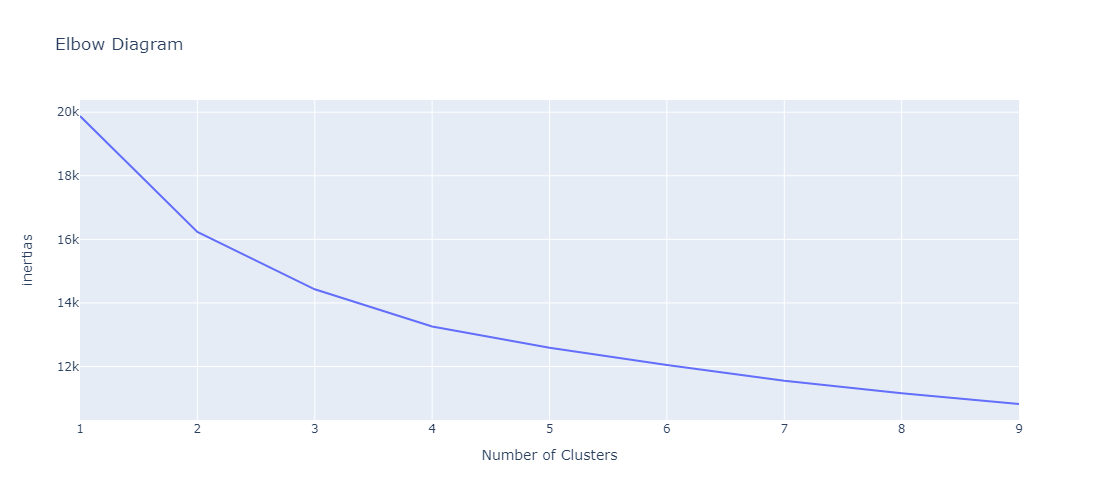

In [63]:
fig = px.line(x=[1,2,3,4,5,6,7,8,9], y=l, title='Elbow Diagram', height=500)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="inertias")
fig.show()

In [64]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(neumerical_df.values)
cluster_labels = kmeans.fit_predict(neumerical_df.values)

C:\Users\rojit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\rojit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.

C:\Users\rojit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\rojit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.



In [65]:
new_df = pd.DataFrame(neumerical_df.values, columns=neumerical_df.columns)
new_df['Cluster'] = cluster_labels

In [66]:
new_df

released_year run_time     stars total_ratings Action Adventure Sci-Fi  \
0         1.099581      2.0 -2.830607     -0.863486    1.0       1.0    1.0   
1         1.038894      0.0  1.801267      1.331283    0.0       0.0    0.0   
2         1.099581      0.0  2.027212     -0.863486    1.0       1.0    0.0   
3         1.038894      1.0  1.688294      0.120553    0.0       0.0    0.0   
4         1.038894      2.0 -0.571157     -0.597844    0.0       0.0    0.0   
...            ...      ...       ...           ...    ...       ...    ...   
3408      0.674143      3.0 -0.571157      -1.21106    0.0       0.0    0.0   
3409      0.552318      2.0 -0.232239      0.120553    1.0       0.0    0.0   
3410     -0.734194      2.0  0.784514     -0.393223    0.0       0.0    0.0   
3411     -1.537414      1.0  0.332624     -0.276862    0.0       0.0    0.0   
3412     -1.475441      2.0  0.106679     -0.090002    1.0       0.0    0.0   

     Comedy Drama Romance Thriller Fantasy Horror Mystery Crime Adults   Kids  \
0       0.0   0.0     0.0      0.0     0.0    0.0     0.0   0.0  False   True   
1       0.0   1.0     0.0      0.0     0.0    0.0     0.0   0.0  False  False   
2       0.0   1.0     0.0      0.0     0.0    0.0     0.0   0.0  False   True   
3       1.0   1.0     1.0      0.0     0.0    0.0     0.0   0.0  False  False   
4       1.0   0.0     1.0      0.0     0.0    0.0     0.0   0.0  False  False   
...     ...   ...     ...      ...     ...    ...     ...   ...    ...    ...   
3408    0.0   1.0     0.0      0.0     0.0    0.0     0.0   0.0  False  False   
3409    0.0   0.0     0.0      1.0     0.0    0.0     0.0   1.0  False  False   
3410    1.0   0.0     0.0      0.0     0.0    0.0     0.0   0.0  False  False   
3411    0.0   1.0     0.0      0.0     0.0    0.0     0.0   0.0  False   True   
3412    1.0   0.0     0.0      0.0     0.0    0.0     0.0   1.0   True  False   

      Other  Teens  Cluster  
0     False  False        1  
1     False   True        3  
2     False  False        3  
3      True  False        3  
4     False   True        2  
...     ...    ...      ...  
3408  False   True        2  
3409  False   True        1  
3410  False   True        0  
3411  False  False        0  
3412  False  False        0  

[3413 rows x 20 columns]

C:\Users\rojit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\rojit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\rojit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\rojit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



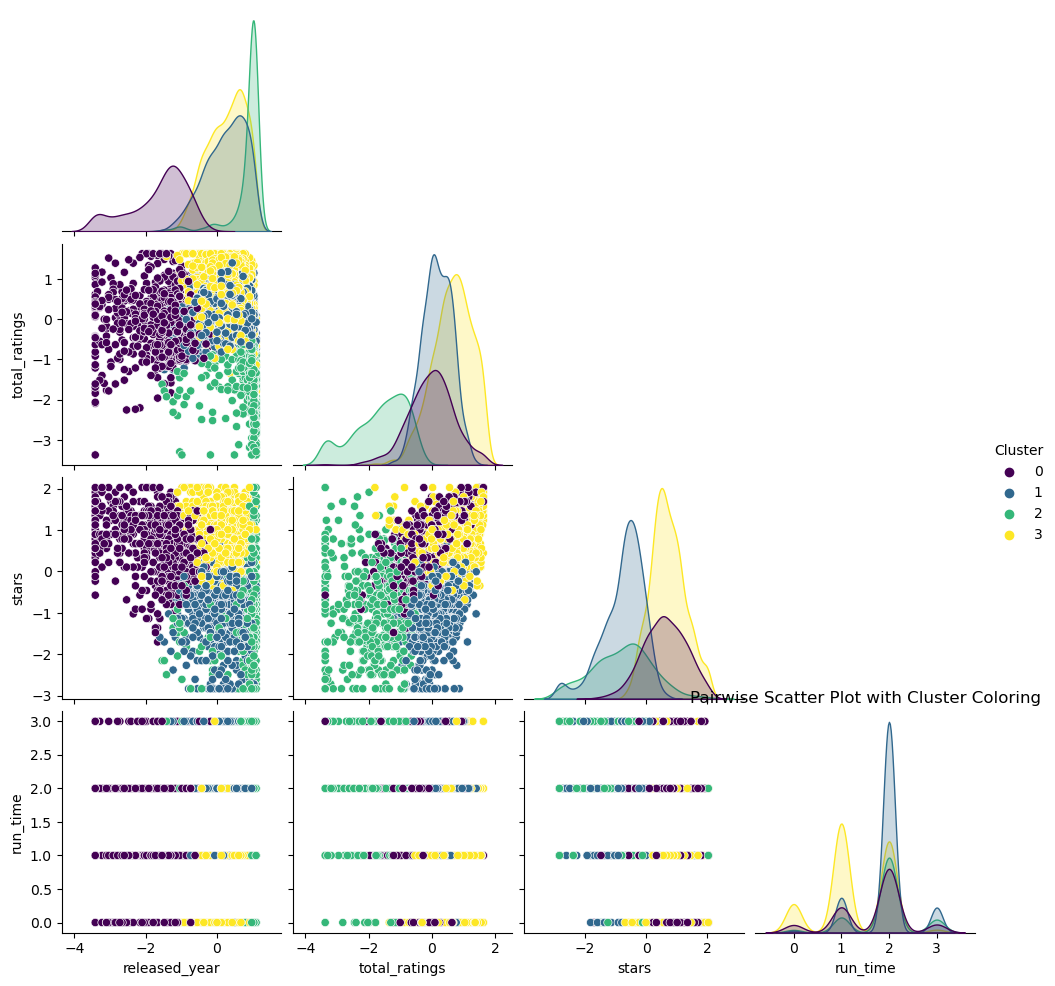

In [67]:
sns.pairplot(new_df[['released_year', 'total_ratings', 'stars', 'run_time', 'Cluster']], hue='Cluster', palette='viridis', corner=True)
plt.title('Pairwise Scatter Plot with Cluster Coloring')
plt.show()